In [1]:
import os
from datetime import datetime

import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import docx
from docx import Document

In [2]:
CREATE_DOCX = True
CREATE_SVG = True

#outputDir = os.path.join('.', 'output')
outputDir = os.path.join('/home/jbecker', 'windows')

In [3]:
# Assemble all JSON files into a single dataframe
RADEON = 'Radeon RX 6800 XT'
XAVIER = 'Xavier NX'
TESLA = 'Tesla V100'

directories = [
    {'device': XAVIER, 'path': os.path.join('..', 'measurements', '20250102-000720600-xavier') },
    {'device': TESLA,  'path': os.path.join('..', 'measurements', '20250101-231415558-fu') },
    {'device': RADEON, 'path': os.path.join('..', 'measurements', '20250102-001021617-amd') }
]

DEVICE_ORDER = { s: idx for idx, s in zip(range(0, len(directories)), [ entry['device'] for entry in directories ]) }

COLKERNEL = {
    'atomic_global': '#FFC000', # yellow
    'atomic_global_stride': '#BE5014', # brownish
    'atomic_private': '#4D93D9', # blue
    'atomic_private_stride': '#D86DCD', # pink
}

In [4]:
if CREATE_DOCX:
    outputDocx = Document()
    section = outputDocx.sections[0]
    # Landscape A3
    section.page_width = docx.shared.Inches(16.54)
    section.page_height = docx.shared.Inches(11.69)
    style = outputDocx.styles['Normal']
    style.font.size = docx.shared.Pt(8)
    
    def createOutputDocxFilename():
        now = datetime.now()
        timestamp = now.strftime('%Y%m%d-%H%M%S') + f"{now.microsecond // 1000:03d}"
        return timestamp + '.docx'
    outputDocxFilename = os.path.join(outputDir, createOutputDocxFilename())

if CREATE_DOCX or CREATE_SVG:
    os.makedirs(outputDir, exist_ok=True)

In [5]:
jsonData = []
for entry in directories:
    device = entry['device']
    jsonDirectory = entry['path']
    for filename in os.listdir(jsonDirectory):
        if not filename.endswith('.json'):
            continue
        filePath = os.path.join(jsonDirectory, filename)
        if not os.path.isfile(filePath):
            continue

        with open(filePath, 'r', encoding='utf-8') as file:
            data = json.load(file)
            jsonData.append({
                'device': device,
                'key': os.path.splitext(os.path.basename(filePath))[0],
                'data': data
            })

# Now jsonData is a list of records.

In [6]:
# Create a single Pandas dataframe from the list of records.
def createDfAll():
    def createDataframe(
        sourceKey,
        device,
        kernelKey,
        mappingLetter,
        uniformInput,
        inputFileName,
        inputLengthInCharacters,
        timesTransferToDevice,
        timesExecution,
        timesTransferFromDevice,
        bins
    ):
        n = len(timesExecution)
        df = pd.DataFrame({
            'sourceKey': [sourceKey] * n,
            'device': [device] * n,
            'kernel': [kernelKey.removeprefix('histogram_')] * n,
            'mappingLetter': [mappingLetter] * n,
            'uniformInput': [uniformInput] * n,
            'inputFileName': [inputFileName] * n,
            'inputLengthInCharacters': [inputLengthInCharacters] * n,
            'timeTransferToDevice': timesTransferToDevice,
            'timeExecution': timesExecution,
            'timeTransferFromDevice': timesTransferFromDevice,
            'timeTotal': None,
            'bins': [bins] * n
        })
        df['timeTotal'] = df['timeTransferToDevice'] + df['timeExecution'] + df['timeTransferFromDevice']
        return df

    dfs = []
    for entry in jsonData:
        device = entry['device']
        sourceKey = entry['key']
        rec = entry['data']
        inputLengthInCharacters = rec['inputLengthInCharacters']
        inputFileName = rec.get('fileName')
        uniformInput = rec['uniformInput']
        mappingLetter = rec['useMappingLetter']
        for k in rec['measurements'].keys():
            measurements = rec['measurements'][k]
            dfs.append(createDataframe(
                sourceKey,
                device,
                k,
                mappingLetter,
                uniformInput,
                inputFileName,
                inputLengthInCharacters,
                measurements['timesTransferToDevice'],
                measurements['timesExecution'],
                measurements['timesTransferFromDevice'],
                measurements['bins']
            ))
    dfAll = pd.concat(dfs)
    dfAll['device'] = pd.Categorical(dfAll['device'], categories=DEVICE_ORDER.keys(), ordered=True)
    return dfAll
dfAll = createDfAll()

In [7]:
dfAll.head()

,sourceKey,device,kernel,mappingLetter,uniformInput,inputFileName,inputLengthInCharacters,timeTransferToDevice,timeExecution,timeTransferFromDevice,timeTotal,bins
0,20250102-000720600-048,Xavier NX,atomic_global,True,False,None,16384,0.117792,0.088896,0.150432,0.357120,"[9786, 253, 253, 249, 282, 236, 259, 236, 254,..."
1,20250102-000720600-048,Xavier NX,atomic_global,True,False,None,16384,0.132160,0.141632,0.113888,0.387680,"[9786, 253, 253, 249, 282, 236, 259, 236, 254,..."
2,20250102-000720600-048,Xavier NX,atomic_global,True,False,None,16384,0.094528,0.105632,0.061088,0.261248,"[9786, 253, 253, 249, 282, 236, 259, 236, 254,..."
3,20250102-000720600-048,Xavier NX,atomic_global,True,False,None,16384,0.097504,0.093920,0.061824,0.253248,"[9786, 253, 253, 249, 282, 236, 259, 236, 254,..."
4,20250102-000720600-048,Xavier NX,atomic_global,True,False,None,16384,0.096000,0.126944,0.061440,0.284384,"[9786, 253, 253, 249, 282, 236, 259, 236, 254,..."


## Messergebnisse für die Beispieldatei

In [8]:
dfTestFile = dfAll[dfAll['inputFileName'].notna()]

Anzahl Zeichen in der Beispieldatei:

In [9]:
s = set(dfTestFile['inputLengthInCharacters'])
if len(s) != 1:
    raise RuntimeError('Something is wrong')
list(s)[0]

10532866

In [10]:
f'{list(s)[0] / 2 ** 20} MiB'

'10.044923782348633 MiB'

Verteilung der Zeichen in der Beispieldatei ("Bin counts" unter `Mapping128`):

In [11]:
binCounts = dfTestFile.iloc[0]['bins']

In [12]:
if CREATE_DOCX:
    def addToDocx(docxObj):
        bcNonZeroRel = [ { 'code': code + 1, 'h': h, 'f': h/sum(binCounts) } for code, h in zip(range(0, len(binCounts)), binCounts) if h != 0 ]
        table = docxObj.add_table(rows=len(bcNonZeroRel)+2, cols=3)
        hdrRow = table.rows[0].cells
        hdrRow[0].text = 'Code'
        hdrRow[1].text = 'Anzahl'
        hdrRow[2].text = 'relative Häufigkeit'
        for i, entry in enumerate(bcNonZeroRel):
            row = table.rows[i+1].cells
            code = entry['code']
            row[0].text = f'{code:0.0f}' + (f' (‘{chr(code)}’)' if code >= 32 else '')
            row[1].text = f'{entry["h"]:0.0f}'
            row[2].text = f'{entry["f"]*100:.3f} %'
            row[0].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
            row[1].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
            row[2].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
        i = len(bcNonZeroRel) + 1
        lastRow = table.rows[i].cells
        lastRow[0].text = 'Summe'
        lastRow[1].text = f'{sum(binCounts):0.0f}'
        lastRow[2].text = f'100 %'
        lastRow[0].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
        lastRow[1].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
        lastRow[2].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
        
    
    # outputDocx = docx.Document()
    addToDocx(outputDocx)
    outputDocx.save(outputDocxFilename)

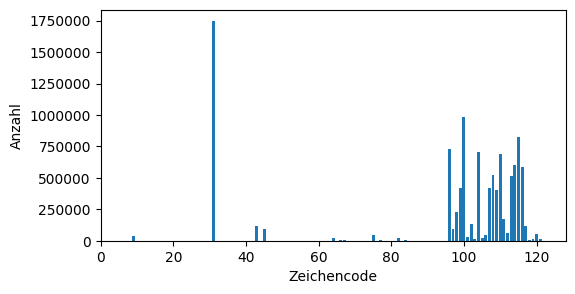

In [13]:
fig = plt.figure(figsize=(6,3))
plt.bar(list(range(0,len(binCounts))), binCounts)
plt.xlim(0, len(binCounts))
fig.axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Zeichencode')
plt.ylabel('Anzahl')
plt.show()

In [14]:
if CREATE_SVG:
    fig.savefig(os.path.join(outputDir, 'freqCharsTestTxt.svg'), format='svg', bbox_inches='tight')

Statistik:

In [15]:
def testFileMakeStatistics(mapping):
    if mapping == 'Mapping128':
        boolMapping = dfTestFile['mappingLetter'] == False
    elif mapping == 'MappingLetter':
        boolMapping = dfTestFile['mappingLetter'] == True
    return dfTestFile[boolMapping].groupby(['device', 'kernel'])[
        ['timeTransferToDevice', 'timeExecution', 'timeTransferFromDevice', 'timeTotal']
    ].agg([
        ('min', lambda x: x.min()),
        ('q10', lambda x: x.quantile(0.1)),
        ('med', lambda x: x.median()),
        ('q90', lambda x: x.quantile(0.5)),
        ('max', lambda x: x.max())
    ])

In [16]:
stat128 = testFileMakeStatistics('Mapping128')
stat128

timeTransferToDevice            \
                                                         min       q10   
device            kernel                                                 
Xavier NX         atomic_global                     1.859968  1.904128   
                  atomic_global_stride              1.848768  1.894723   
                  atomic_private                    1.644448  1.867248   
                  atomic_private_stride             1.417408  1.737389   
Tesla V100        atomic_global                     6.614880  6.615424   
                  atomic_global_stride              6.615168  6.615837   
                  atomic_private                    6.614784  6.615168   
                  atomic_private_stride             6.615136  6.615837   
Radeon RX 6800 XT atomic_global                     1.170269  1.183840   
                  atomic_global_stride              1.162018  1.177639   
                  atomic_private                    1.171099  1.174735   
                  atomic_private_stride             1.166298  1.173754   

                                                                        \
                                              med       q90        max   
device            kernel                                                 
Xavier NX         atomic_global          2.015552  2.015552   2.482592   
                  atomic_global_stride   2.044224  2.044224   2.382560   
                  atomic_private         1.933840  1.933840   2.245472   
                  atomic_private_stride  1.916256  1.916256   2.309472   
Tesla V100        atomic_global          6.616128  6.616128   6.665664   
                  atomic_global_stride   6.616816  6.616816   6.640544   
                  atomic_private         6.616016  6.616016   6.639776   
                  atomic_private_stride  6.616496  6.616496   6.620480   
Radeon RX 6800 XT atomic_global          1.193629  1.193629  11.573335   
                  atomic_global_stride   1.190083  1.190083   2.217415   
                  atomic_private         1.178979  1.178979   2.087654   
                  atomic_private_stride  1.180994  1.180994   2.059554   

                                        timeExecution                      \
                                                  min       q10       med   
device            kernel                                                    
Xavier NX         atomic_global              9.492736  9.515946  9.560944   
                  atomic_global_stride       9.555008  9.586333  9.606464   
                  atomic_private             2.011904  2.037408  2.068832   
                  atomic_private_stride      1.023488  1.038422  1.057568   
Tesla V100        atomic_global              3.232256  3.233088  3.233616   
                  atomic_global_stride       3.232416  3.233562  3.234272   
                  atomic_private             0.305952  0.307392  0.308016   
                  atomic_private_stride      0.065440  0.066422  0.067632   
Radeon RX 6800 XT atomic_global              1.031707  1.032607  1.033757   
                  atomic_global_stride       1.035287  1.037477  1.039712   
                  atomic_private             0.112281  0.113598  0.114640   
                  atomic_private_stride      0.064681  0.065936  0.067236   

                                                             \
                                              q90       max   
device            kernel                                      
Xavier NX         atomic_global          9.560944  9.814304   
                  atomic_global_stride   9.606464  9.744960   
                  atomic_private         2.068832  2.239808   
                  atomic_private_stride  1.057568  1.216992   
Tesla V100        atomic_global          3.233616  3.241888   
                  atomic_global_stride   3.234272  3.238592   
                  atomic_private         0.308016  0.310272   
                  atomic_private

In [17]:
statLetter = testFileMakeStatistics('MappingLetter')
statLetter

timeTransferToDevice            \
                                                         min       q10   
device            kernel                                                 
Xavier NX         atomic_global                     1.849568  1.936656   
                  atomic_global_stride              1.850816  1.896691   
                  atomic_private                    1.515840  1.622691   
                  atomic_private_stride             1.365952  1.390083   
Tesla V100        atomic_global                     6.610688  6.617184   
                  atomic_global_stride              6.616128  6.617440   
                  atomic_private                    6.616672  6.617184   
                  atomic_private_stride             6.616352  6.616893   
Radeon RX 6800 XT atomic_global                     1.237059  1.240427   
                  atomic_global_stride              1.227409  1.239401   
                  atomic_private                    1.216109  1.224060   
                  atomic_private_stride             1.218889  1.224843   

                                                                       \
                                              med       q90       max   
device            kernel                                                
Xavier NX         atomic_global          2.044912  2.044912  2.239840   
                  atomic_global_stride   2.006080  2.006080  2.216384   
                  atomic_private         1.839984  1.839984  2.127872   
                  atomic_private_stride  1.477968  1.477968  2.230336   
Tesla V100        atomic_global          6.618848  6.618848  6.667264   
                  atomic_global_stride   6.619296  6.619296  6.648192   
                  atomic_private         6.618800  6.618800  6.647520   
                  atomic_private_stride  6.618544  6.618544  6.631680   
Radeon RX 6800 XT atomic_global          1.244923  1.244923  2.544499   
                  atomic_global_stride   1.244274  1.244274  2.127724   
                  atomic_private         1.230279  1.230279  2.132015   
                  atomic_private_stride  1.230549  1.230549  2.139594   

                                        timeExecution                        \
                                                  min        q10        med   
device            kernel                                                      
Xavier NX         atomic_global             11.243040  11.265773  11.289440   
                  atomic_global_stride      11.324160  11.337747  11.362288   
                  atomic_private             2.059136   2.076458   2.110160   
                  atomic_private_stride      1.055488   1.070963   1.091072   
Tesla V100        atomic_global              3.854496   3.855389   3.856032   
                  atomic_global_stride       3.855072   3.856768   3.857520   
                  atomic_private             0.164736   0.165651   0.166304   
                  atomic_private_stride      0.065824   0.067286   0.068432   
Radeon RX 6800 XT atomic_global              1.270049   1.271290   1.271699   
                  atomic_global_stride       1.273209   1.274049   1.275454   
                  atomic_private             0.114801   0.116821   0.117741   
                  atomic_private_stride      0.068601   0.070870   0.071556   

                                                               \
                                               q90        max   
device            kernel                                        
Xavier NX         atomic_global          11.289440  11.403168   
                  atomic_global_stride   11.362288  11.484832   
                  atomic_private          2.110160   2.268160   
                  atomic_private_stride   1.091072   1.246784   
Tesla V100        atomic_global           3.856032   3.862624   
                  atomic_global_stride    3.857520   3.865504   
                  atomic_private          0.166304   0.187904 

In [18]:
if CREATE_DOCX:
    def addToDocx(docxObj, df):
        dff = df.reset_index()
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.3f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, stat128)
    outputDocx.add_paragraph()
    addToDocx(outputDocx, statLetter)
    outputDocx.save(outputDocxFilename)

### Untersuchung der Transferzeiten auf das Device

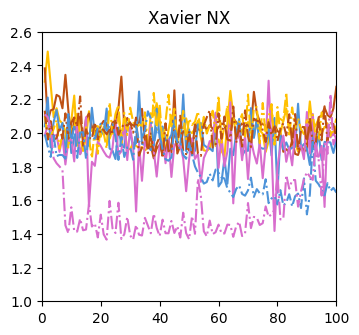

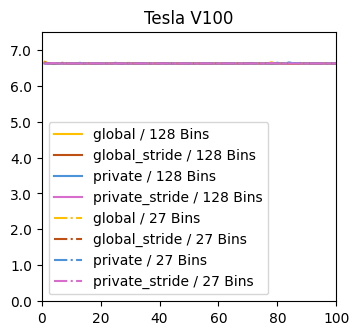

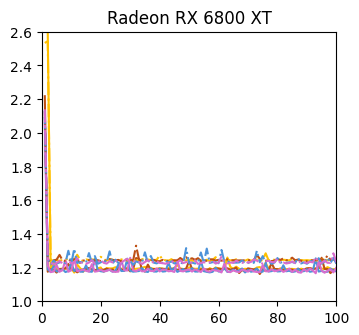

In [19]:
for device, grp in dfTestFile.groupby('device'):
    fig, ax = plt.subplots(figsize=(3.8,3.5))
    plt.title(device)
    grouped = grp.groupby(['mappingLetter', 'kernel'])
    maxy = 0
    for (mappingLetter, name), group in grouped:
        c = group['timeTransferToDevice']
        maxy = max(maxy, max(c))
        plt.plot(range(1,len(c)+1),c, label=f'{name.removeprefix("atomic_")} / {"27 Bins" if mappingLetter else "128 Bins"}', color=COLKERNEL[name],
                linestyle=('dashdot' if mappingLetter else 'solid'))
    plt.xlim(0,len(c))
    if device == TESLA:
        plt.ylim(0,7.5)
    else:
        plt.ylim(1, 2.6)
    def format_func(value, tick_number):
        return f'{value:.1f}'  # Format with 1 decimal place

    # Apply the formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    if device == TESLA:
        plt.legend()
    plt.show()

    if CREATE_SVG:
        abbrev = {
            RADEON: 'Radeon',
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }
        fig.savefig(os.path.join(outputDir, f'transferHostDevice{abbrev[device]}TestTxt.svg'), format='svg', bbox_inches='tight')

### Untersuchung der Transferzeiten vom Device

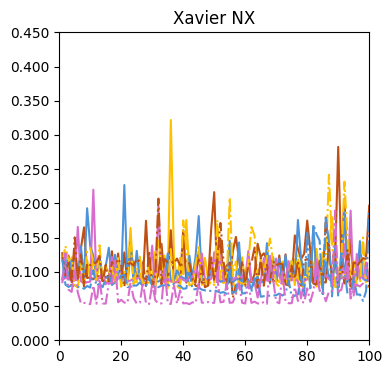

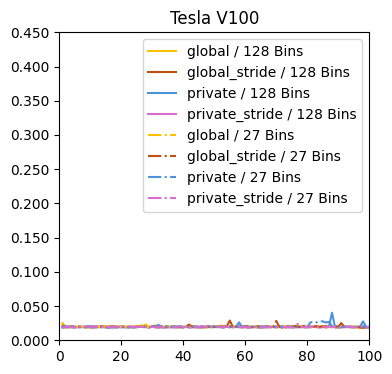

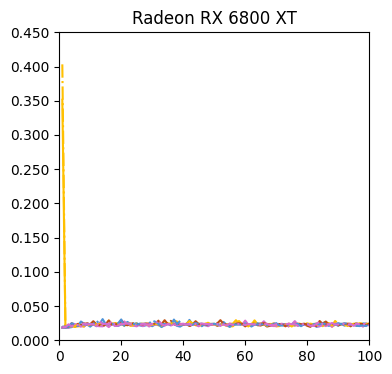

In [20]:
for device, grp in dfTestFile.groupby('device'):
    fig, ax = plt.subplots(figsize=(4,4))
    plt.title(device)
    grouped = grp.groupby(['mappingLetter', 'kernel'])
    maxy = 0
    for (mappingLetter, name), group in grouped:
        c = group['timeTransferFromDevice']
        maxy = max(maxy, max(c))
        plt.plot(range(1,len(c)+1),c, label=f'{name.removeprefix("atomic_")} / {"27 Bins" if mappingLetter else "128 Bins"}', color=COLKERNEL[name],
                linestyle=('dashdot' if mappingLetter else 'solid'))
    plt.xlim(0,len(c))
    plt.ylim(0, 0.45)
    def format_func(value, tick_number):
        return f'{value:.3f}'  # Format with 1 decimal place

    # Apply the formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    if device == TESLA:
        plt.legend()
    plt.show()

    if CREATE_SVG:
        abbrev = {
            RADEON: 'Radeon',
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }    
        fig.savefig(os.path.join(outputDir, f'transferDeviceHost{abbrev[device]}TestTxt.svg'), format='svg', bbox_inches='tight')

### Untersuchung der Ausführungszeiten

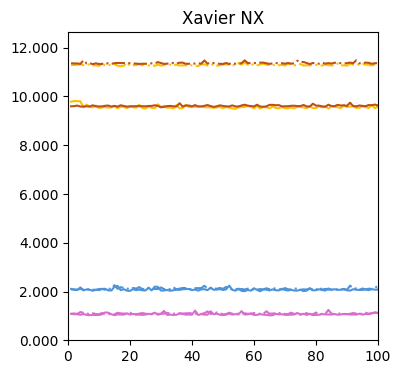

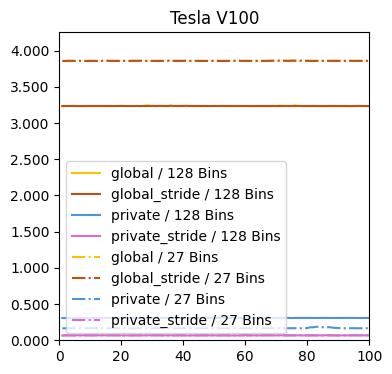

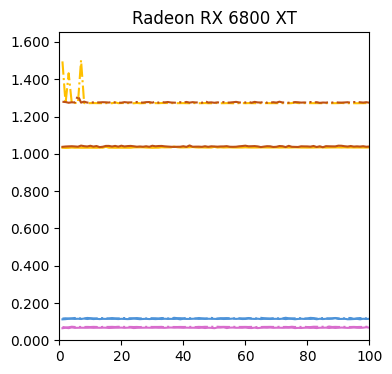

In [21]:
for device, grp in dfTestFile.groupby('device'):
    fig, ax = plt.subplots(figsize=(4,4))
    plt.title(device)
    grouped = grp.groupby(['mappingLetter', 'kernel'])
    maxy = 0
    for (mappingLetter, name), group in grouped:
        c = group['timeExecution']
        maxy = max(maxy, max(c))
        plt.plot(range(1,len(c)+1),c, label=f'{name.removeprefix("atomic_")} / {"27 Bins" if mappingLetter else "128 Bins"}', color=COLKERNEL[name],
                linestyle=('dashdot' if mappingLetter else 'solid'))
    plt.xlim(0,len(c))
    plt.ylim(0, 1.1 * maxy)
    def format_func(value, tick_number):
        return f'{value:.3f}'  # Format with 1 decimal place

    # Apply the formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    if device == TESLA:
        plt.legend()
    plt.show()

    if CREATE_SVG:
        abbrev = {
            RADEON: 'Radeon',
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }    
        fig.savefig(os.path.join(outputDir, f'execution{abbrev[device]}TestTxt.svg'), format='svg', bbox_inches='tight')

Ausführungszeiten für die einzelnen Kernels für die beiden Mappings:

In [22]:
data1 = stat128['timeExecution']['med']
data2 = statLetter['timeExecution']['med']

data1.index = pd.MultiIndex.from_tuples([(x, 'Mapping128', z) for x, z in data1.index], names=['device', 'mapping', 'kernel'])
data2.index = pd.MultiIndex.from_tuples([(x, 'MappingLetter', z) for x, z in data2.index], names=['device', 'mapping', 'kernel'])
s = pd.concat([data1, data2]).sort_index(level=0).unstack(level=1).unstack(level=1)

s.index = pd.Categorical(s.index, categories=DEVICE_ORDER.keys(), ordered=True)
s = s.sort_index()
s

mapping              Mapping128                                      \
kernel            atomic_global atomic_global_stride atomic_private   
Xavier NX              9.560944             9.606464       2.068832   
Tesla V100             3.233616             3.234272       0.308016   
Radeon RX 6800 XT      1.033757             1.039712       0.114640   

mapping                                 MappingLetter                       \
kernel            atomic_private_stride atomic_global atomic_global_stride   
Xavier NX                      1.057568     11.289440            11.362288   
Tesla V100                     0.067632      3.856032             3.857520   
Radeon RX 6800 XT              0.067236      1.271699             1.275454   

mapping                                                 
kernel            atomic_private atomic_private_stride  
Xavier NX               2.110160              1.091072  
Tesla V100              0.166304              0.068432  
Radeon RX 6800 XT       0.117741              0.071556

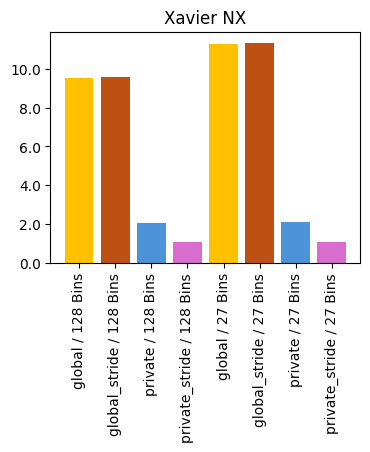

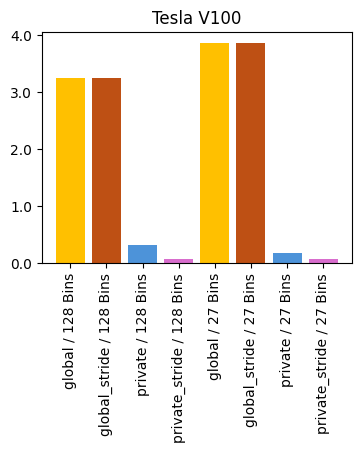

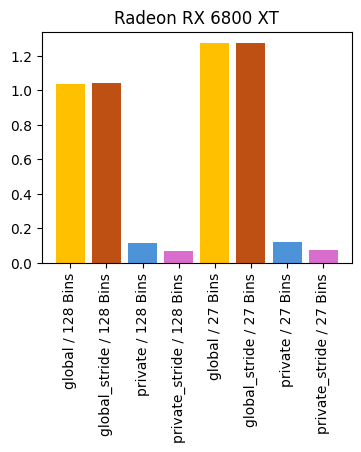

In [23]:
for r in range(0,s.shape[0]):
    heights = s.iloc[r]
    fig = plt.figure(figsize=(4,3))
    plt.bar([
            f'{name.removeprefix("atomic_")} / {"27 Bins" if mapping == "MappingLetter" else "128 Bins"}' for mapping, name in s.columns
        ],
        heights, color=[COLKERNEL[name] for mapping, name in s.columns]
    )

    plt.xticks(rotation=90)
    def format_func(value, tick_number):
        return f'{value:.1f}'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    device = s.index[r]
    plt.title(device)
    plt.show()

    if CREATE_SVG:
        abbrev = {
            RADEON: 'Radeon',
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }    
        fig.savefig(os.path.join(outputDir, f'executionBar{abbrev[device]}TestTxt.svg'), format='svg', bbox_inches='tight')

Speedup in den Ausführungszeiten:

In [24]:
OTPC = 'atomic_global'
speedup = s.copy() # probably inefficient way of copying the layout of the dataframe
for m in set(s.columns.get_level_values(0)):
    n = s[(m, OTPC)]
    for h in set(s.columns.get_level_values(1)):
        speedup[(m, h)] = n / s[(m, h)]
speedup

mapping              Mapping128                                      \
kernel            atomic_global atomic_global_stride atomic_private   
Xavier NX                   1.0             0.995262       4.621421   
Tesla V100                  1.0             0.999797      10.498208   
Radeon RX 6800 XT           1.0             0.994272       9.017420   

mapping                                 MappingLetter                       \
kernel            atomic_private_stride atomic_global atomic_global_stride   
Xavier NX                      9.040500           1.0             0.993589   
Tesla V100                    47.811923           1.0             0.999614   
Radeon RX 6800 XT             15.375166           1.0             0.997056   

mapping                                                 
kernel            atomic_private atomic_private_stride  
Xavier NX               5.350040             10.347109  
Tesla V100             23.186646             56.348374  
Radeon RX 6800 XT      10.800821             17.772088

In [25]:
if CREATE_DOCX:
    def addToDocx(docxObj, df):
        dff = df.reset_index()
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.2f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, speedup)
    outputDocx.add_paragraph()
    
    outputDocx.save(outputDocxFilename)

In [26]:
letterPenalty = pd.DataFrame({
    h: s[('MappingLetter', h)] / s[('Mapping128', h)] for h in s.columns.get_level_values(1)
})

In [27]:
if CREATE_DOCX:
    def addToDocx(docxObj, df):
        dff = df.reset_index()
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.3f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, letterPenalty)
    outputDocx.add_paragraph()
    
    outputDocx.save(outputDocxFilename)

## Untersuchung der Messergebnisse für die generierten Daten

In [28]:
dfGenerated = dfAll[dfAll['inputFileName'].isna()]

Verteilung der Zeichen für eine Eingabegrösse von 2^30 (= 1 GiB):

In [29]:
counts = dfGenerated[
    (dfGenerated['inputLengthInCharacters']==2**30) *
    (dfGenerated['uniformInput'] == False)
]['bins'].iloc[0]
print('rel. dev. ', (max(counts) - min(counts)) / sum(counts))
print('min rel. freq. ', max(counts) / sum(counts))
print('max rel. freq. ', max(counts) / sum(counts))

rel. dev.  0.578113560564816
min rel. freq.  0.5937325293198228
max rel. freq.  0.5937325293198228


In [30]:
def createStatisticsForGeneratedData(mapping):
    if mapping == 'Mapping128':
        boolMapping = dfGenerated['mappingLetter'] == False
    elif mapping == 'MappingLetter':
        boolMapping = dfGenerated['mappingLetter'] == True
    else:
        raise RuntimeError('Invalid parameter value: mapping')
    #boolUniform = dfGenerated['uniformInput'] == uniform
    return dfGenerated[
        boolMapping #* boolUniform
    ].groupby(['device', 'uniformInput', 'inputLengthInCharacters', 'kernel'])[
        ['timeTransferToDevice', 'timeExecution', 'timeTransferFromDevice', 'timeTotal']
    ].agg([
        ('min', lambda x: x.min()),
        ('q10', lambda x: x.quantile(0.1)),
        ('med', lambda x: x.median()),
        ('q90', lambda x: x.quantile(0.5)),
        ('max', lambda x: x.max())
    ])

In [31]:
genStat128 = createStatisticsForGeneratedData('Mapping128')
genStat128

timeTransferToDevice  \
                                                                                              min   
device            uniformInput inputLengthInCharacters kernel                                       
Xavier NX         False        8                       atomic_global                     0.020736   
                                                       atomic_global_stride              0.020960   
                                                       atomic_private                    0.020032   
                                                       atomic_private_stride             0.020192   
                               16                      atomic_global                     0.018272   
...                                                                                           ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride           116.880280   
                               4294967296              atomic_global                          NaN   
                                                       atomic_global_stride            226.236099   
                                                       atomic_private                         NaN   
                                                       atomic_private_stride           226.385635   

                                                                                          \
                                                                                     q10   
device            uniformInput inputLengthInCharacters kernel                              
Xavier NX         False        8                       atomic_global            0.021504   
                                                       atomic_global_stride     0.021693   
                                                       atomic_private           0.020957   
                                                       atomic_private_stride    0.022650   
                               16                      atomic_global            0.018806   
...                                                                                  ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride  117.206991   
                               4294967296              atomic_global                 NaN   
                                                       atomic_global_stride   226.474539   
                                                       atomic_private                NaN   
                                                       atomic_private_stride  226.732941   

                                                                                          \
                                                                                     med   
device            uniformInput inputLengthInCharacters kernel                              
Xavier NX         False        8                       atomic_global            0.025504   
                                                       atomic_global_stride     0.022688   
                                                       atomic_private           0.021936   
                                                       atomic_private_stride    0.024256   
                               16                      atomic_global            0.019488   
...                                                                                  ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride  118.216492   
                               4294967296              atomic_global                 NaN   
                                                       atomic_global_stride   226.892151   
                                                       atomic_private                NaN   
                                                       atomic_private_stride  227.304291   

                                                                                    

In [32]:
genStatLetter = createStatisticsForGeneratedData('MappingLetter')
genStatLetter

timeTransferToDevice  \
                                                                                              min   
device            uniformInput inputLengthInCharacters kernel                                       
Xavier NX         False        8                       atomic_global                     0.018464   
                                                       atomic_global_stride              0.018272   
                                                       atomic_private                    0.018400   
                                                       atomic_private_stride             0.018368   
                               16                      atomic_global                     0.017856   
...                                                                                           ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride           118.420197   
                               4294967296              atomic_global                          NaN   
                                                       atomic_global_stride            225.562561   
                                                       atomic_private                         NaN   
                                                       atomic_private_stride           225.372421   

                                                                                          \
                                                                                     q10   
device            uniformInput inputLengthInCharacters kernel                              
Xavier NX         False        8                       atomic_global            0.018813   
                                                       atomic_global_stride     0.018912   
                                                       atomic_private           0.018688   
                                                       atomic_private_stride    0.018877   
                               16                      atomic_global            0.018208   
...                                                                                  ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride  119.743135   
                               4294967296              atomic_global                 NaN   
                                                       atomic_global_stride   225.731573   
                                                       atomic_private                NaN   
                                                       atomic_private_stride  225.748645   

                                                                                          \
                                                                                     med   
device            uniformInput inputLengthInCharacters kernel                              
Xavier NX         False        8                       atomic_global            0.019760   
                                                       atomic_global_stride     0.020032   
                                                       atomic_private           0.019616   
                                                       atomic_private_stride    0.020976   
                               16                      atomic_global            0.019616   
...                                                                                  ...   
Radeon RX 6800 XT True         2147483648              atomic_private_stride  121.579639   
                               4294967296              atomic_global                 NaN   
                                                       atomic_global_stride   226.022812   
                                                       atomic_private                NaN   
                                                       atomic_private_stride  226.133575   

                                                                                    

In [33]:
if CREATE_DOCX:
    def addToDocx(docxObj, dff):
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.3f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    def reduceGenStat(genStat):
        gs = genStat.reset_index()
        return gs[gs[('inputLengthInCharacters','')].isin(
            [2 ** i for i in [19, 23, 27, 31]]
        )].drop([(a,b) for a, b in gs.columns if a == 'timeTransferFromDevice'], axis=1)
    genStat128Reduced = reduceGenStat(genStat128)
    genStatLetterReduced = reduceGenStat(genStatLetter)
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, genStat128Reduced)
    outputDocx.add_paragraph()
    addToDocx(outputDocx, genStatLetterReduced)
    outputDocx.save(outputDocxFilename)

In [34]:
def getColorForDataVariantAndKernel(kernel, uniform):
    def darken_hex_color(hex_color, factor=0.4):
        # delivered by ChatGPT :-)
        # Ensure the color starts with #
        if not hex_color.startswith("#"):
            hex_color = "#" + hex_color
    
        # Convert hex to RGB
        r = int(hex_color[1:3], 16)
        g = int(hex_color[3:5], 16)
        b = int(hex_color[5:7], 16)
    
        # Darken each component
        r = max(0, int(r * (1 - factor)))
        g = max(0, int(g * (1 - factor)))
        b = max(0, int(b * (1 - factor)))
    
        # Convert back to hex
        return f"#{r:02x}{g:02x}{b:02x}"
    return darken_hex_color(COLKERNEL[kernel]) if uniform else COLKERNEL[kernel]
    
def createPlotsForGeneratedData(genStat, mappingAbbrev):
    grouped = genStat.reset_index().groupby('device')

    for device, grp in grouped:
        fig = plt.figure(figsize=(4,4))
        by_kernel = grp.groupby(['uniformInput', 'kernel'])
        for (uniform, kernel), g in by_kernel:
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'q10')], color=getColorForDataVariantAndKernel(kernel, uniform), linestyle='--')
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'med')], color=getColorForDataVariantAndKernel(kernel, uniform),
                    label=f'{kernel.removeprefix("atomic_")} / {"const" if uniform else "rand"}')
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'q90')], color=getColorForDataVariantAndKernel(kernel, uniform), linestyle='--')
        plt.xscale('log', base=2)
        plt.yscale('log', base=10)
        plt.xlim(2 ** 3)
        plt.ylim(10 ** -2, 10 ** 4)
        plt.title(f'{device} / {"128" if mappingAbbrev == "128" else "27"} Bins')
        if device == RADEON and mappingAbbrev == 'Letter':
            plt.legend()
        plt.show()

        if CREATE_SVG:
            abbrev = {
                RADEON: 'Radeon',
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }    
            fig.savefig(os.path.join(outputDir, f'execution{abbrev[device]}{mappingAbbrev}Generated.svg'), format='svg', bbox_inches='tight')

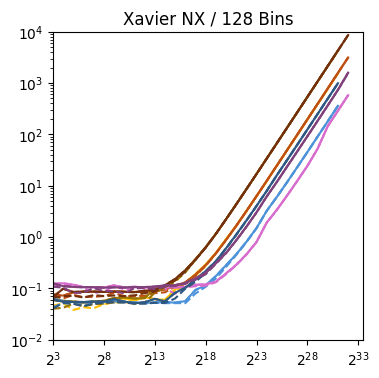

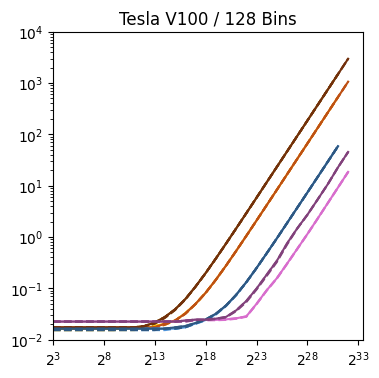

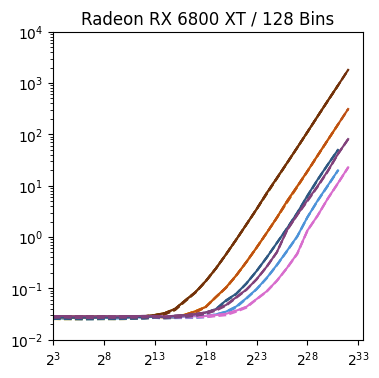

In [35]:
createPlotsForGeneratedData(genStat128, '128')

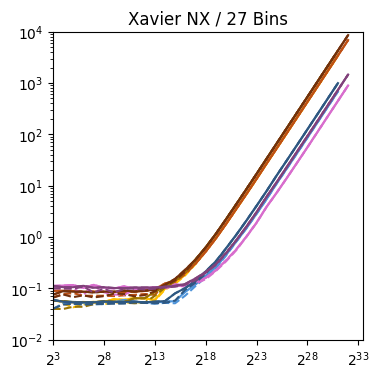

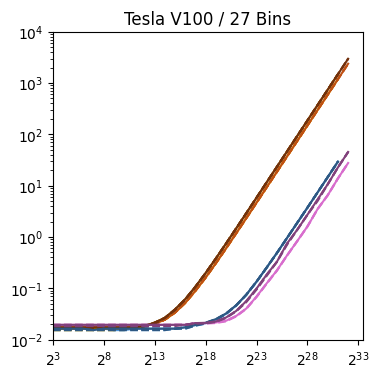

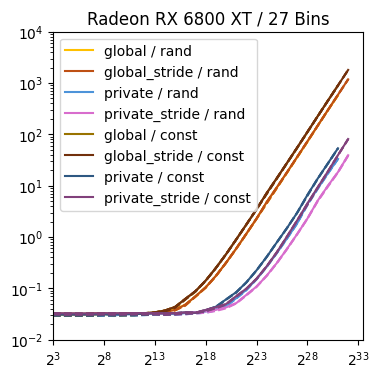

In [36]:
createPlotsForGeneratedData(genStatLetter, 'Letter')

In [37]:
def calculateSpeedups(genStat):
    s = genStat.loc[:,('timeExecution', 'med')].unstack(level=1).unstack(level=2)
    OTPC = 'atomic_global'
    speedup = s.copy() # probably inefficient way of copying the layout of the dataframe

    for m in set(s.columns.get_level_values(0)):
        n = s[(m, OTPC)]
        for h in set(s.columns.get_level_values(1)):
            speedup[(m, h)] = n / s[(m, h)]
    return speedup

In [38]:
speedupsGenStat128 = calculateSpeedups(genStat128)
speedupsGenStat128

uniformInput                                      False                       \
kernel                                    atomic_global atomic_global_stride   
device            inputLengthInCharacters                                      
Xavier NX         8                                 1.0             0.821309   
                  16                                1.0             0.794986   
                  32                                1.0             0.666474   
                  64                                1.0             0.608048   
                  128                               1.0             0.644052   
...                                                 ...                  ...   
Radeon RX 6800 XT 268435456                         1.0             0.993059   
                  536870912                         1.0             0.998991   
                  1073741824                        1.0             0.994168   
                  2147483648                        1.0             0.995246   
                  4294967296                        NaN                  NaN   

uniformInput                                              \
kernel                                    atomic_private   
device            inputLengthInCharacters                  
Xavier NX         8                             1.001791   
                  16                            0.999721   
                  32                            1.012899   
                  64                            1.000000   
                  128                           0.992183   
...                                                  ...   
Radeon RX 6800 XT 268435456                     7.834874   
                  536870912                     7.556191   
                  1073741824                    7.665266   
                  2147483648                    7.801017   
                  4294967296                         NaN   

uniformInput                                                            True   \
kernel                                    atomic_private_stride atomic_global   
device            inputLengthInCharacters                                       
Xavier NX         8                                    0.509697           1.0   
                  16                                   0.456375           1.0   
                  32                                   0.469493           1.0   
                  64                                   0.492754           1.0   
                  128                                  0.519794           1.0   
...                                                         ...           ...   
Radeon RX 6800 XT 268435456                           14.234276           1.0   
                  536870912                           14.821233           1.0   
                  1073741824                          13.761273           1.0   
                  2147483648                          13.827646           1.0   
                  4294967296                                NaN           NaN   

uniformInput                                                                   \
kernel                                    atomic_global_stride atomic_private   
device            inputLengthInCharacters                                       
Xavier NX         8                                   0.883009       0.989628   
                  16                                  0.562571       0.999711   
                  32                                  0.650423       1.018262   
                  64                                  0.615939       0.982017   
                  128                                 0.636062       1.000580   
...                                                        ...            ...   
Radeon RX 6800 XT 268435456                           0.990112      17.247324   
                  536870912                           0.999019      17.086189   
            

In [39]:
speedupsGenStatLetter = calculateSpeedups(genStatLetter)
speedupsGenStatLetter

uniformInput                                      False                       \
kernel                                    atomic_global atomic_global_stride   
device            inputLengthInCharacters                                      
Xavier NX         8                                 1.0             0.646187   
                  16                                1.0             0.608842   
                  32                                1.0             0.611391   
                  64                                1.0             0.621940   
                  128                               1.0             0.626819   
...                                                 ...                  ...   
Radeon RX 6800 XT 268435456                         1.0             0.980988   
                  536870912                         1.0             0.999582   
                  1073741824                        1.0             0.998252   
                  2147483648                        1.0             0.977514   
                  4294967296                        NaN                  NaN   

uniformInput                                              \
kernel                                    atomic_private   
device            inputLengthInCharacters                  
Xavier NX         8                             0.989336   
                  16                            0.994778   
                  32                            0.994721   
                  64                            1.005742   
                  128                           1.004427   
...                                                  ...   
Radeon RX 6800 XT 268435456                    16.176374   
                  536870912                    16.793275   
                  1073741824                   17.004335   
                  2147483648                   17.303931   
                  4294967296                         NaN   

uniformInput                                                            True   \
kernel                                    atomic_private_stride atomic_global   
device            inputLengthInCharacters                                       
Xavier NX         8                                    0.518635           1.0   
                  16                                   0.484459           1.0   
                  32                                   0.467218           1.0   
                  64                                   0.525170           1.0   
                  128                                  0.464827           1.0   
...                                                         ...           ...   
Radeon RX 6800 XT 268435456                           31.317526           1.0   
                  536870912                           28.951656           1.0   
                  1073741824                          29.762879           1.0   
                  2147483648                          31.384981           1.0   
                  4294967296                                NaN           NaN   

uniformInput                                                                   \
kernel                                    atomic_global_stride atomic_private   
device            inputLengthInCharacters                                       
Xavier NX         8                                   0.762067       0.965517   
                  16                                  0.639520       1.022972   
                  32                                  0.619048       1.000000   
                  64                                  0.630952       1.020150   
                  128                                 0.639931       0.996705   
...                                                        ...            ...   
Radeon RX 6800 XT 268435456                           0.986999      16.733721   
                  536870912                           1.002213      16.407443   
            

In [40]:
def createSpeedupPlotsForGeneratedData(genStat, mappingAbbrev):
    grouped = genStat.reset_index().groupby('device')

    for device, grp in grouped:
        fig = plt.figure(figsize=(4,4))
        for uniform in [False, True]:
            for kernel in COLKERNEL.keys():
                plt.plot(grp['inputLengthInCharacters'], grp[(uniform, kernel)], color=getColorForDataVariantAndKernel(kernel, uniform),
                    label=f'{kernel.removeprefix("atomic_")} / {"const" if uniform else "rand"}')
        plt.xscale('log', base=2)
        plt.yscale('log', base=2)
        plt.xlim(2 ** 3, 2 ** 32)
        plt.ylim(2 ** -2, 2 ** 7)
        plt.title(f'{device} / {"128" if mappingAbbrev == "128" else "27"} Bins')
        if device == RADEON and mappingAbbrev == 'Letter':
            plt.legend()
        plt.show()

        if CREATE_SVG:
            abbrev = {
                RADEON: 'Radeon',
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }    
            fig.savefig(os.path.join(outputDir, f'executionSpeedup{abbrev[device]}{mappingAbbrev}Generated.svg'), format='svg', bbox_inches='tight')

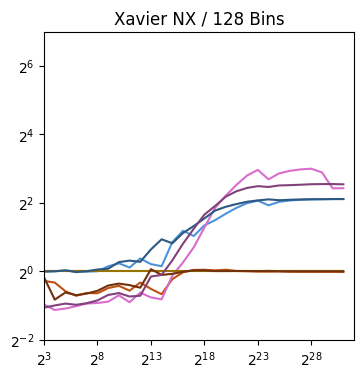

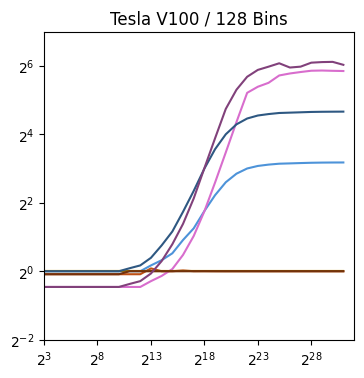

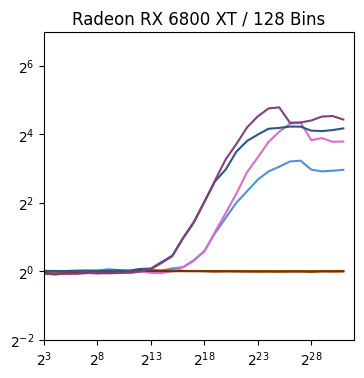

In [41]:
createSpeedupPlotsForGeneratedData(speedupsGenStat128, '128')

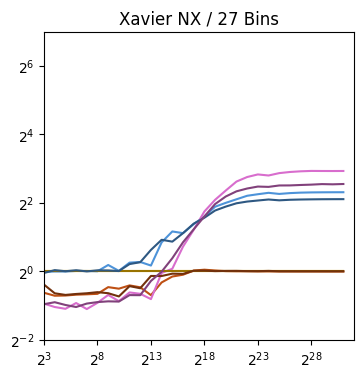

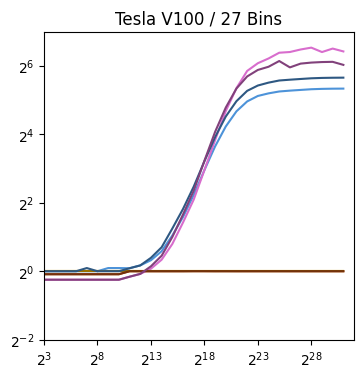

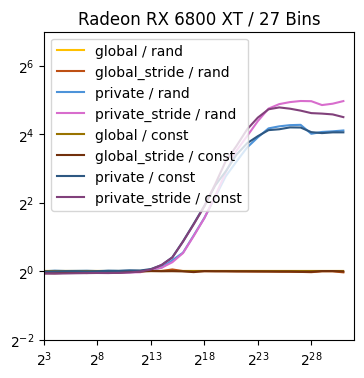

In [42]:
createSpeedupPlotsForGeneratedData(speedupsGenStatLetter, 'Letter')

In [43]:
def prepareForDivision(genStat):
    return genStat.loc[:,('timeExecution', 'med')].unstack(level=1).unstack(level=2)
letterPenalty = prepareForDivision(genStatLetter) / prepareForDivision(genStat128)

letterPenalty

uniformInput                                      False                       \
kernel                                    atomic_global atomic_global_stride   
device            inputLengthInCharacters                                      
Xavier NX         8                            0.923902             1.174287   
                  16                           0.957019             1.249612   
                  32                           0.981766             1.070216   
                  64                           1.019608             0.996833   
                  128                          0.992997             1.020297   
...                                                 ...                  ...   
Radeon RX 6800 XT 268435456                    3.760040             3.806308   
                  536870912                    3.786403             3.784163   
                  1073741824                   3.806367             3.790795   
                  2147483648                   3.723822             3.791369   
                  4294967296                        NaN             3.785266   

uniformInput                                              \
kernel                                    atomic_private   
device            inputLengthInCharacters                  
Xavier NX         8                             0.935533   
                  16                            0.961775   
                  32                            0.999707   
                  64                            1.013787   
                  128                           0.980892   
...                                                  ...   
Radeon RX 6800 XT 268435456                     1.821140   
                  536870912                     1.703705   
                  1073741824                    1.715846   
                  2147483648                    1.678786   
                  4294967296                         NaN   

uniformInput                                                            True   \
kernel                                    atomic_private_stride atomic_global   
device            inputLengthInCharacters                                       
Xavier NX         8                                    0.907979      0.963182   
                  16                                   0.901541      1.017645   
                  32                                   0.986547      0.962684   
                  64                                   0.956673      1.018313   
                  128                                  1.110420      0.964348   
...                                                         ...           ...   
Radeon RX 6800 XT 268435456                            1.708993      1.002098   
                  536870912                            1.938375      0.999345   
                  1073741824                           1.759926      0.999720   
                  2147483648                           1.640648      0.992208   
                  4294967296                           1.719961           NaN   

uniformInput                                                                   \
kernel                                    atomic_global_stride atomic_private   
device            inputLengthInCharacters                                       
Xavier NX         8                                   1.116042       0.987234   
                  16                                  0.895199       0.994505   
                  32                                  1.011477       0.980265   
                  64                                  0.994083       0.980248   
                  128                                 0.958518       0.968097   
...                                                        ...            ...   
Radeon RX 6800 XT 268435456                           1.005259       1.032856   
                  536870912                           0.996160       1.040686   
            

In [44]:
def createLetterPenaltyPlotsForGeneratedData(letterPenalty):
    grouped = letterPenalty.reset_index().groupby('device')

    col = {
        (False, 'atomic_global'): 'green',
        (True, 'atomic_global'): 'darkgreen',
        (False, 'atomic_private'): 'blue',
        (True, 'atomic_private'): 'darkblue',
        (False, 'atomic_private_stride'): 'orange',
        (True, 'atomic_private_stride'): 'darkorange',
        (False, 'atomic_global_stride'): 'brown',
        (True, 'atomic_global_stride'): 'black',
    }

    for device, grp in grouped:
        fig = plt.figure(figsize=(4,4))
        for uniform in [False, True]:
            for kernel in COLKERNEL.keys():
                plt.plot(grp['inputLengthInCharacters'], grp[(uniform, kernel)], color=getColorForDataVariantAndKernel(kernel, uniform),
                    label=f'{kernel.removeprefix("atomic_")} / {"const" if uniform else "rand"}')
        plt.xscale('log', base=2)
        plt.yscale('log', base=2)
        plt.xlim(2 ** 3, 2 ** 32)
        plt.ylim(2 ** -2, 2 ** 3)
        plt.title(f'{device}')
        if device == RADEON:
            plt.legend(loc='lower left', ncol=2)
        plt.show()

        if CREATE_SVG:
            abbrev = {
                RADEON: 'Radeon',
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }    
            fig.savefig(os.path.join(outputDir, f'executionLetterPenalty{abbrev[device]}Generated.svg'), format='svg', bbox_inches='tight')

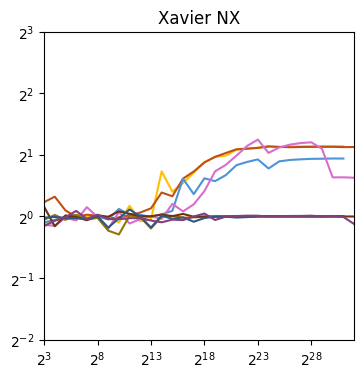

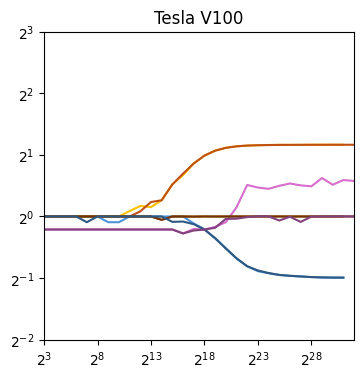

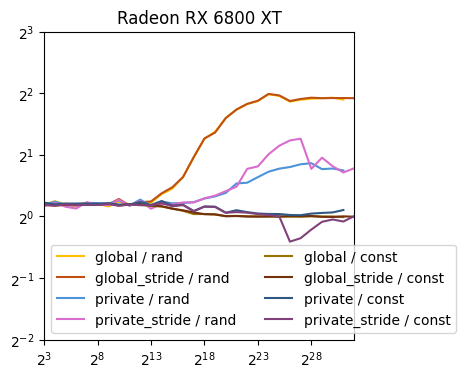

In [45]:
createLetterPenaltyPlotsForGeneratedData(letterPenalty)